## SETUP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer, load_boston

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier, 
                              GradientBoostingRegressor)

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ( 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    roc_auc_score,
    
    mean_squared_error)

from sklearn.model_selection import (
    KFold,
    cross_validate,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

Cargamos datos para ejemplificar

In [3]:
# Cargamos los datos
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)

X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

# Partimos en train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

## __`Busquedas manuales`__

Es la forma más simple de buscar hiperparametros, solo consiste en variar manualmente los valores y estudiar los resultados finales de cada combinación probada

#### Modelo 1

probamos con `C = 0.001`, `penalty = 'l1'`

In [4]:
# Logistic Regression
lr = LogisticRegression(penalty ='l1', 
                        C=0.01, 
                        solver='liblinear', 
                        random_state=123, 
                        max_iter=10000)

# Esquema K-Fold Cross-Validation
kf = KFold(n_splits=5, 
           shuffle=True, 
           random_state=123)

# estimamos el error generalizado
clf =  cross_validate(lr,
                      X_train, 
                      y_train,
                      scoring='roc_auc',
                      return_train_score=True,
                      cv=kf)

In [5]:
# obtenemos el diccionario con los resultados
type(clf)

dict

In [6]:
clf.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

In [7]:
clf['test_score']

array([0.98901099, 0.95123626, 0.93021725, 0.99667553, 0.97755102])

In [8]:
clf['train_score']

array([0.96593531, 0.98175106, 0.98016949, 0.96682745, 0.9702521 ])

In [9]:
print(np.mean(clf['test_score']))
print(np.std(clf['test_score']))

0.9689382106519815
0.024735107731352995


In [10]:
print(np.mean(clf['train_score']))
print(np.std(clf['train_score']))

0.9729870828541657
0.006686448196780827


In [11]:
# Ajustamos el modelo con todos los datos
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=10000, penalty='l1', random_state=123,
                   solver='liblinear')

In [12]:
# Creamos pronosticos
test_preds = lr.predict(X_test)
print(accuracy_score(y_test, test_preds))

0.9473684210526315


#### Modelo 2

probamos con `C = 1`, `penalty = 'l2'`

In [13]:
# # Logistic Regression
# lr = LogisticRegression(penalty ='l1', 
#                         C=0.01, 
#                         solver='liblinear', 
#                         random_state=123, 
#                         max_iter=10000)

# # Esquema K-Fold Cross-Validation
# kf = KFold(n_splits=5, 
#            shuffle=True, 
#            random_state=123)

# # estimamos el error generalizado
# clf =  cross_validate(lr,
#                       X_train, 
#                       y_train,
#                       scoring='roc_auc',
#                       return_train_score=True,
#                       cv=kf)

In [14]:
# Logistic Regression
lr = LogisticRegression(penalty ='l2', 
                        C=1, 
                        solver='liblinear', 
                        random_state=123, 
                        max_iter=10000)

# Esquema K-Fold Cross-Validation
kf = KFold(n_splits=5, 
           shuffle=True, 
           random_state=123)

# estimamos el error generalizado
clf =  cross_validate(lr,
                      X_train, 
                      y_train,
                      scoring='accuracy',
                      return_train_score=True,
                      cv=kf)

In [15]:
print(np.mean(clf['test_score']))
print(np.std(clf['test_score']))

0.9422784810126583
0.030272655391901895


In [16]:
print(np.mean(clf['train_score']))
print(np.std(clf['train_score']))

0.9604286193095563
0.007319240455215062


In [17]:
# Ajustamos el modelo con todos los datos
lr.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=10000, random_state=123, solver='liblinear')

In [18]:
# Creamos pronosticos
test_preds = lr.predict(X_test)
print(accuracy_score(y_test, test_preds))

0.9649122807017544


In [19]:
0.9473684210526315

0.9473684210526315

## __`GridSearchCV`__

Pasos en una búsqueda de hiperparámetros con __`GridSearchCV`__:

1. Instanciar un algoritmo (estimador) para ajustar hiperparámetros
2. Definir qué hiperparámetros serán ajustados
3. Definir un rango de valores para cada hiperparámetro
4. Establecer un esquema de cross validation
5. Definir una métrica (recall, presicion, RMSE, etc.) para que podamos decidir qué combinación de hiperparámetros es la mejor
6. Incluir información extra o funciones adicionales útiles

Los argumentos del __[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)__ son:

* `estimator`, el algoritmo que será usado (knn, RandomForest, etc.)
* `param_grid`, diccionadrio de hiperparámetros y sus valores que serán probados
* `cv`, esquema de validación cruzada que será usado
* `scoring`, métrica usada para evaluar el performance del modelo
* `refit`, (True/False) si es True, ajustará un modelo sobre todos los datos usando los mejores hiperparámetros encontrados, esto implica que el objeto __`GridSearchCV`__ ahora pasará a ser usado como un estimador
* `n_jobs`, para ejecutar la busqueda en paralelo
* `return_train_score` es el log de las estadísticas que fueron tomadas, es útil para entender el performance de training vs test
* `verbose`, Controla los mensajes que se imprimen al momento de hacer los ajustes

In [20]:
# cores disponibles
import os
os.cpu_count()

2

In [21]:
# partimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

Debemos traer el GridSearchCV

```python
from sklearn.model_selection import GridSearchCV
```



In [22]:
# Instanciamos el modelo
gbm = GradientBoostingClassifier(random_state=0)

Creamos el grid de parametros, que es un diccionario donde:

*   las llaves del diccionario son los hiperparametros que vamos a calibrar
*   los valores del diccionario son listas con los valores de los respectivos hiperparametros que seran probados

Ejemplo:

```python
param_grid = {'hiperparametro_01': [valor_h11, valor_h12, valor_h13], 
              'hiperparametro_02': [valor_h21, valor_h22, valor_h23],
              '...':[...],
              'hiperparametro_N':[valor_hN1, valor_hN2, valor_N3]
              }
```



In [23]:
# Creamos el grid de nuestro ejercicio
param_grid = {'n_estimators': [50, 100, 150],
              'min_samples_split': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [2, 5, 10, 15],
              }

In [24]:
print('Numero de combinaciones entre los parametros a probar:')
print(len(param_grid['n_estimators'])*len(param_grid['min_samples_split'])*len(param_grid['max_depth']))

Numero de combinaciones entre los parametros a probar:
48


In [25]:
# Supongamos que queremos probar con un esquema de 10 validaciones crizadas

In [26]:
10*48

480

In [27]:
# aun falta ajustar el modelo final con los mejores hiperparametros enmcontrados
10*48 + 1

481

In [28]:
# Instanciamos el GridSearchCV
grid_gbm_search = GridSearchCV(estimator=gbm,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               n_jobs=-1, # Cuando colocamos menos 1 quiere decir que usaremos todos los cores disponibles en nuestra maquina
                               verbose = True,
                               cv=4,
                               refit=True, 
                               return_train_score=True)

In [29]:
%%time
# Buscamos y ajustamos  hiperparametros con los datos de entrenamiento
grid_gbm_search.fit(X_train, y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
CPU times: user 1.88 s, sys: 127 ms, total: 2 s
Wall time: 1min 17s


GridSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15],
                         'min_samples_split': [0.1, 0.3, 0.5, 0.7],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='roc_auc', verbose=True)

In [30]:
type(grid_gbm_search)

sklearn.model_selection._search.GridSearchCV

In [31]:
dir(grid_gbm_search)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_

In [32]:
# Usamos grid_rf_class para generar predicciones
y_pred = grid_gbm_search.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))
print('-'*30)
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       108
           1       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

------------------------------
0.9828042328042329


### Resultados del __`GridSearchCV`__

* log de resultados
    + `.cv_results_` (diccionario de resultados)

* Mejores resultados
    + `.best_index_` (indice del mejor modelo), `.best_params_` (mejores parámetros) & `.best_score_` (mejor score)

* Información extra
    + `.scorer_` (métrica usada), `.n_splits_` (k usado en cv) & `.refit_time_` (tiempos)

In [34]:
# Creamos el grid de nuestro ejercicio
param_grid = {'n_estimators': [50, 100, 150],
              'min_samples_split': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [2, 5, 10, 15],
              }

In [35]:
# podemos extrae los mejores hiperparametros para despues intentar ajustar un nuevo modelo
print(grid_gbm_search.best_params_) 

{'max_depth': 5, 'min_samples_split': 0.5, 'n_estimators': 150}


In [36]:
# podemos obtener la metrica promedio del proceso de validación cruzada
print(grid_gbm_search.best_score_) 

0.9898031368744443


In [37]:
grid_gbm_search.cv_results_

{'mean_fit_time': array([0.37506062, 0.89902031, 0.67812121, 0.26654267, 0.69991517,
        0.89845622, 0.47771645, 0.66603529, 0.79504937, 0.21747088,
        0.69060814, 0.66551799, 0.60487533, 1.15850407, 1.70915574,
        0.54791003, 1.13368112, 1.5082745 , 0.46641821, 0.98082352,
        1.04275483, 0.10974598, 0.26778024, 0.41904604, 0.50771046,
        1.0122335 , 1.54231578, 0.46365339, 0.94228446, 1.44665915,
        0.2750386 , 0.53345472, 0.76967525, 0.11510855, 0.26370871,
        0.41958922, 0.77000529, 1.53161341, 1.98800606, 0.5534119 ,
        1.1240598 , 1.65047497, 0.27502322, 0.52762157, 0.81379175,
        0.11782461, 0.26538509, 0.41961592]),
 'std_fit_time': array([0.22659978, 0.53261123, 0.33482708, 0.18423689, 0.22518912,
        0.40572496, 0.2474387 , 0.41912456, 0.48723645, 0.12884582,
        0.30935714, 0.17077564, 0.10772236, 0.1284945 , 0.20925737,
        0.08807903, 0.12764335, 0.1577207 , 0.1541651 , 0.25400237,
        0.1447614 , 0.00161473, 0.020

In [38]:
# podemos obtener todos los resultados
results = (pd.DataFrame(grid_gbm_search.cv_results_)
            #  .sort_values(by='mean_test_score', 
            #               ascending=False)
            #  .reset_index(drop=True)
             )

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.375061,0.226600,0.010079,0.008638,2,0.1,50,"{'max_depth': 2, 'min_samples_split': 0.1, 'n_...",0.986486,0.985993,...,0.990846,0.986690,0.002664,28,1.0,1.0,1.0,1.0,1.0,0.000000e+00
1,0.899020,0.532611,0.004945,0.000305,2,0.1,100,"{'max_depth': 2, 'min_samples_split': 0.1, 'n_...",0.985628,0.986842,...,0.996513,0.987887,0.005219,16,1.0,1.0,1.0,1.0,1.0,5.551115e-17
2,0.678121,0.334827,0.005161,0.000749,2,0.1,150,"{'max_depth': 2, 'min_samples_split': 0.1, 'n_...",0.986486,0.985993,...,0.997384,0.987998,0.005676,15,1.0,1.0,1.0,1.0,1.0,0.000000e+00
3,0.266543,0.184237,0.008487,0.005779,2,0.3,50,"{'max_depth': 2, 'min_samples_split': 0.3, 'n_...",0.986486,0.984720,...,0.993025,0.987462,0.003272,21,1.0,1.0,1.0,1.0,1.0,0.000000e+00
4,0.699915,0.225189,0.010146,0.009178,2,0.3,100,"{'max_depth': 2, 'min_samples_split': 0.3, 'n_...",0.985628,0.983447,...,0.996077,0.986929,0.005398,25,1.0,1.0,1.0,1.0,1.0,7.850462e-17


In [39]:
results[['mean_test_score','mean_train_score']].head()

,mean_test_score,mean_train_score
0,0.986690,1.0
1,0.987887,1.0
2,0.987998,1.0
3,0.987462,1.0
4,0.986929,1.0


In [40]:
print(results.mean_train_score.mean())
print(results.mean_test_score.mean())

0.9998411191855808
0.9861964342578998


Text(0.5, 0, 'Combinaciones de hiperparametros')

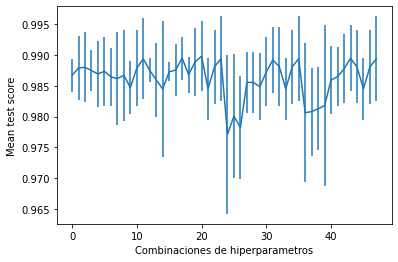

In [41]:
# Graficamos los resultados
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Combinaciones de hiperparametros')

## __`RandomizedSearchCV`__

Referecnias:

1. [Randomized search on hyper parameters](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
2. [Randomized Parameter Optimization](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)

In [42]:
from sklearn.model_selection import RandomizedSearchCV

In [43]:
# Partimos los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

__`RandomizedSearchCV`__ toma muestras de los rangos seleccionados en el __param grid__, para esta tarea podemos usar:

* `stats.randint(i, n)` para tomar una muestra de enteros en el intervalo (i, n) 
* `stats.uniform(a, b)` para tomar una muestra de los reales en el intervalo (a, b) 
* `(class_01, class_02, class_03, class_04)` para seleccionar alguna de las clases

In [44]:
# # instanciamos un gbm
gbm = GradientBoostingClassifier(random_state=0)

In [45]:
# Creamos el espacio de hiperparametros
param_grid = dict(
    n_estimators=stats.randint(50, 150),
    min_samples_split=stats.uniform(.1, .7),
    max_depth=stats.randint(2, 15)
    )

Con el parametro `n_iter` indicamos cuantos ajustes deseamos que sean realizados

In [46]:
# Create el objeto RandomizedSearchCV
rand_gbm_search = RandomizedSearchCV(gbm,
                                     param_grid,
                                     scoring='roc_auc',
                                     cv=4,
                                     n_iter = 40, # Con este argumento indicamos cuantas muestras queremos que sean tomadas (arriba de 40 es un bune numero)
                                     random_state=10,
                                     n_jobs=-1,
                                     refit=True)

In [47]:
%%time
rand_gbm_search.fit(X_train, y_train)

CPU times: user 1.73 s, sys: 49.9 ms, total: 1.78 s
Wall time: 39.3 s


RandomizedSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc03d774dd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc03d774290>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc03d774590>},
                   random_state=10, scoring='roc_auc')

In [48]:
# Usamos random_rf para generar predicciones
y_pred = rand_gbm_search.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred))
print('-'*30)
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       108
           1       0.98      0.97      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

------------------------------
0.9794973544973545


In [50]:
print(rand_gbm_search.best_params_)

{'max_depth': 5, 'min_samples_split': 0.36420846531236595, 'n_estimators': 112}


In [51]:
results = (pd.DataFrame(rand_gbm_search.cv_results_)
             .sort_values(by='mean_test_score', ascending=False)
             .reset_index(drop=True))

In [52]:
(results
 .loc[:,['param_max_depth', 
         'param_min_samples_split', 
         'param_n_estimators',
         'mean_test_score', 
         'std_test_score',]]
 .head(3))

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,5,0.364208,112,0.990586,0.004564
1,3,0.742442,127,0.989603,0.006588
2,5,0.127971,67,0.989499,0.002226


Text(0.5, 0, 'Combinaciones de hiperparametros')

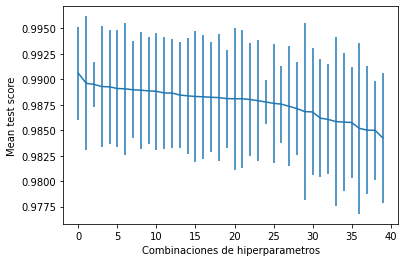

In [53]:
# Graficamos el performance del modelo y el error
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Combinaciones de hiperparametros')

## Métodos de optimización bayesiana

* [scikit opt](https://scikit-optimize.github.io/stable/)
* [optuna](https://optuna.org/)
* [hyperopt](https://github.com/hyperopt/hyperopt)

### scikit opt

In [54]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.8 MB/s 


In [55]:
from skopt import BayesSearchCV

In [56]:
# load dataset
boston_X, boston_y = load_boston(return_X_y=True)
X = pd.DataFrame(boston_X)
y = pd.Series(boston_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [57]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

In [58]:
# set up the model
gbm = GradientBoostingRegressor(random_state=0)

In [59]:
# hyperparameter space

param_grid = {
    'n_estimators': (10, 120), 
    'min_samples_split': (0.001, 0.99, 'log-uniform'),
    'max_depth': (1, 8),
    'loss': ['ls', 'lad', 'huber'],
}

In [60]:
# set up the search
search = BayesSearchCV(estimator=gbm,
                       search_spaces=param_grid,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       n_iter=30,
                       random_state=10,
                       n_jobs=-1,
                       refit=True)

In [61]:
# find best hyperparameters
search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
              n_iter=30, n_jobs=-1, random_state=10,
              scoring='neg_mean_squared_error',
              search_spaces={'loss': ['ls', 'lad', 'huber'],
                             'max_depth': (1, 8),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (10, 120)})

In [62]:
# the best hyperparameters are stored in an attribute
search.best_params_

OrderedDict([('loss', 'huber'),
             ('max_depth', 3),
             ('min_samples_split', 0.001),
             ('n_estimators', 119)])

In [63]:
# the best score
search.best_score_

-11.101044956670878

In [64]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head(5)

(30, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.346457,0.064629,0.002877,0.000626,huber,3,0.044228,80,"{'loss': 'huber', 'max_depth': 3, 'min_samples...",-10.558287,-16.394026,-13.460963,-13.471092,2.382441,14
1,0.072526,0.012192,0.004331,0.001889,ls,2,0.308189,76,"{'loss': 'ls', 'max_depth': 2, 'min_samples_sp...",-11.740731,-18.260354,-14.708708,-14.903264,2.665178,19
2,0.210915,0.017882,0.003122,0.000260,lad,3,0.002288,48,"{'loss': 'lad', 'max_depth': 3, 'min_samples_s...",-9.253265,-17.728812,-18.140297,-15.040791,4.095845,20
3,0.190761,0.053897,0.003343,0.000059,ls,5,0.001897,90,"{'loss': 'ls', 'max_depth': 5, 'min_samples_sp...",-17.641456,-26.860518,-9.886990,-18.129655,6.938007,26
4,0.075521,0.007050,0.003012,0.000707,ls,4,0.054687,54,"{'loss': 'ls', 'max_depth': 4, 'min_samples_sp...",-11.734966,-26.734377,-11.014968,-16.494771,7.246459,23


Text(0.5, 0, 'Hyperparameter combinations')

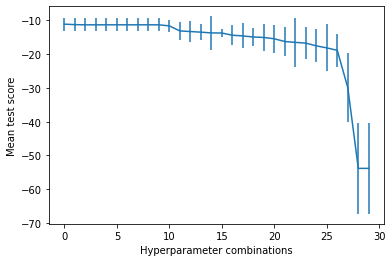

In [65]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [66]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, X_train_preds)**(1/2))
print('Test RMSE: ', mean_squared_error(y_test, X_test_preds)**(1/2))

Train RMSE:  1.139724546394376
Test RMSE:  4.009622818665551


Nota para guardar modelos revisar la siguiente [liga](https://scikit-learn.org/stable/model_persistence.html) (NO USAR PICKLs)

## Ejercicios

Considera los datos de `Heart_Attack.csv` y el siguiente preprocesamiento:

In [67]:
# Cargamos los datos
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)

X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

# Partimos en train y test

In [68]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

In [69]:
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val,
                                                test_size=0.3,
                                                random_state=0)

La idea es encontrar el mejor modelo y por cada modelo tunear sus hiperparametros, antes de empezar los ejercicios parte los datos en train y test, entrena todos los modelos con train y test usalo al final para evaluarlos todos

### Ejercicio 01

Ajusta una __regresión logística__ y tunea sus hiperparametros con `.GridSearchCV/RandomizedSearchCV`

In [70]:
# Respuesta
lr=LogisticRegression(solver='liblinear',random_state=123,max_iter=10000)

In [84]:
param_grid=dict(penalty = ('l1','l2','elasticnet','none'),
                C=stats.uniform(6,0.01))

In [85]:
rand_lr_search= RandomizedSearchCV(lr,
                                   param_grid,
                                   scoring='roc_auc',
                                   cv=3,
                                   n_iter=20,
                                   random_state=10,
                                   n_jobs=-1,
                                   refit=True)    

In [86]:
%%time
rand_lr_search.fit(X_train,y_train)

CPU times: user 198 ms, sys: 8.38 ms, total: 206 ms
Wall time: 2.8 s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
21 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 459, in _check_solver
    solver
ValueError: Only 'saga' solver 

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=10000,
                                                random_state=123,
                                                solver='liblinear'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc03bdd32d0>,
                                        'penalty': ('l1', 'l2', 'elasticnet',
                                                    'none')},
                   random_state=10, scoring='roc_auc')

In [87]:
rand_lr_search.best_params_

{'C': 6.0014217004760155, 'penalty': 'l2'}

In [88]:
y_pred=rand_lr_search.predict(X_val)

In [89]:
print(classification_report(y_val,y_pred))
print('-'*30)
print(roc_auc_score(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97        78
           1       0.91      0.98      0.94        41

    accuracy                           0.96       119
   macro avg       0.95      0.96      0.95       119
weighted avg       0.96      0.96      0.96       119

------------------------------
0.9621638524077548


### Ejercicio 02

Ajusta un __random forest__ y tunea sus hiperparametros con `.GridSearchCV/RandomizedSearchCV`

In [91]:
# Respuesta
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=123)

param_grid=dict(n_estimators=(list(range(1,101,5))),
          criterion=['gini', 'entropy', 'log_loss'],
          max_depth=list(range(1,11))
)



In [92]:
rand_rfc_search= RandomizedSearchCV(rfc,
                                   param_grid,
                                   scoring='roc_auc',
                                   cv=3,
                                   n_iter=20,
                                   random_state=10,
                                   n_jobs=-1,
                                   refit=True)    

In [93]:
%%time
rand_rfc_search.fit(X_train,y_train)

CPU times: user 477 ms, sys: 35.3 ms, total: 513 ms
Wall time: 7.19 s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=123),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_estimators': [1, 6, 11, 16, 21, 26,
                                                         31, 36, 41, 46, 51, 56,
                                                         61, 66, 71, 76, 81, 86,
                                                         91, 96]},
                   random_state=10, scoring='roc_auc')

In [94]:
rand_rfc_search.best_params_

{'n_estimators': 61, 'max_depth': 5, 'criterion': 'entropy'}

In [95]:
y_pred=rand_rfc_search.predict(X_val)

In [96]:
print(classification_report(y_val,y_pred))
print('-'*30)
print(roc_auc_score(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95        78
           1       0.90      0.93      0.92        41

    accuracy                           0.94       119
   macro avg       0.93      0.94      0.94       119
weighted avg       0.94      0.94      0.94       119

------------------------------
0.9377736085053158


In [99]:
results = (pd.DataFrame(rand_rfc_search.cv_results_)
             .sort_values(by='mean_test_score', ascending=False)
             .reset_index(drop=True))
(results
 .loc[:,['param_max_depth',  
         'param_n_estimators',
         'mean_test_score', 
         'std_test_score',]]
 .head(3))

,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,5,61,0.990210,0.003927
1,5,96,0.988883,0.004805
2,6,86,0.988722,0.005274


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:959: UserWarning: Warning: converting a masked element to nan.
  x = np.asarray(x)


Text(0.5, 0, 'Combinaciones de hiperparametros')

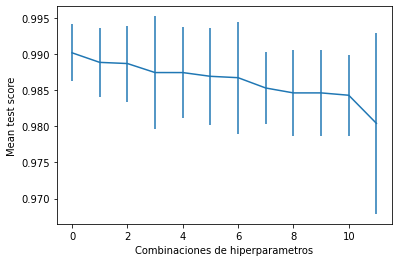

In [100]:
# Graficamos el performance del modelo y el error
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Combinaciones de hiperparametros')

### Ejercicio 03

Ajusta un __xgbm__ y tunea sus hiperparametros con `.GridSearchCV/RandomizedSearchCV`

In [104]:
# Respuesta
import xgboost as xgb

xg_cl = xgb.XGBClassifier(objective='binary:logistic', 
                          n_estimators=100, 
                          seed=123,
                          learning_rate = 0.01)


In [105]:
param_grid =dict(n_estimators= (list(range(1,150,5))),
              learning_rate=[0.01, 0.01, 0.1, 10,100],
              max_depth= list(range(1,15)),
)

In [106]:
rand_xgb_search= RandomizedSearchCV(xg_cl,
                                   param_grid,
                                   scoring='roc_auc',
                                   cv=3,
                                   n_iter=20,
                                   random_state=10,
                                   n_jobs=-1,
                                   refit=True)    

In [107]:
%%time
rand_xgb_search.fit(X_train,y_train)

CPU times: user 375 ms, sys: 53.9 ms, total: 429 ms
Wall time: 5.77 s


RandomizedSearchCV(cv=3, estimator=XGBClassifier(learning_rate=0.01, seed=123),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.01, 0.1, 10,
                                                          100],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'n_estimators': [1, 6, 11, 16, 21, 26,
                                                         31, 36, 41, 46, 51, 56,
                                                         61, 66, 71, 76, 81, 86,
                                                         91, 96, 101, 106, 111,
                                                         116, 121, 126, 131,
                                                         136, 141, 146]},
                   random_state=10, scoring='roc_auc')

In [108]:
rand_xgb_search.best_params_

{'n_estimators': 121, 'max_depth': 13, 'learning_rate': 0.1}

In [109]:
y_pred=rand_xgb_search.predict(X_val)

In [110]:
print(classification_report(y_val,y_pred))
print('-'*30)
print(roc_auc_score(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        78
           1       0.97      0.90      0.94        41

    accuracy                           0.96       119
   macro avg       0.96      0.94      0.95       119
weighted avg       0.96      0.96      0.96       119

------------------------------
0.9448092557848655


In [113]:
results = (pd.DataFrame(rand_xgb_search.cv_results_)
             .sort_values(by='mean_test_score', ascending=False)
             .reset_index(drop=True))
(results
 .loc[:,['param_max_depth',  
         'param_n_estimators',
         'mean_test_score', 
         'std_test_score',]]
 .head(3))

,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,13,121,0.990011,0.005849
1,9,86,0.989845,0.005213
2,5,71,0.988635,0.004922


Text(0.5, 0, 'Combinaciones de hiperparametros')

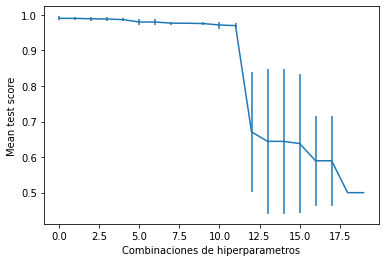

In [114]:
# Graficamos el performance del modelo y el error
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Combinaciones de hiperparametros')

### Ejercicio 04

Ajusta un __lgbm__ y tunea sus hiperparametros con `.GridSearchCV/RandomizedSearchCV`

In [79]:
# Respuesta
import lightgbm as lgb

In [115]:
lgbm= lgb.LGBMClassifier()

In [117]:
param_grid={'n_estimators':list(range(40,70)),
            'learning_rate':stats.uniform(0.001,0.9),
            'reg_lambda':stats.uniform(1,15),
            'max_depth':stats.randint(40,50)

}

In [121]:
rand_lgbm_search=RandomizedSearchCV(lgbm,
                             param_grid,
                             scoring='roc_auc',
                             cv=3,
                             n_iter=20,
                             random_state=10,
                             n_jobs=-1,
                             refit=True)

In [124]:
%%time
rand_lgbm_search.fit(X_train,y_train)

CPU times: user 178 ms, sys: 4.92 ms, total: 183 ms
Wall time: 1.42 s


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc031c1a150>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc031c22350>,
                                        'n_estimators': [40, 41, 42, 43, 44, 45,
                                                         46, 47, 48, 49, 50, 51,
                                                         52, 53, 54, 55, 56, 57,
                                                         58, 59, 60, 61, 62, 63,
                                                         64, 65, 66, 67, 68,
                                                         69],
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc031c1af50>},
                   random_state=10, scoring='roc_auc')

In [125]:
rand_lgbm_search.best_params_

{'learning_rate': 0.2996940301009452,
 'max_depth': 49,
 'n_estimators': 55,
 'reg_lambda': 6.032494697798049}

In [126]:
y_pred=rand_lgbm_search.predict(X_val)

In [127]:
print(classification_report(y_val,y_pred))
print('-'*30)
print(roc_auc_score(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97        78
           1       0.93      0.95      0.94        41

    accuracy                           0.96       119
   macro avg       0.95      0.96      0.95       119
weighted avg       0.96      0.96      0.96       119

------------------------------
0.9563789868667918


In [128]:
results = (pd.DataFrame(rand_lgbm_search.cv_results_)
             .sort_values(by='mean_test_score', ascending=False)
             .reset_index(drop=True))
(results
 .loc[:,['param_max_depth',  
         'param_n_estimators',
         'mean_test_score', 
         'std_test_score',]]
 .head(3))

,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,49,55,0.990409,0.004632
1,49,69,0.990157,0.004626
2,45,53,0.990084,0.004411


Text(0.5, 0, 'Combinaciones de hiperparametros')

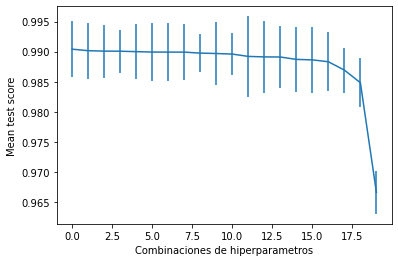

In [129]:
# Graficamos el performance del modelo y el error
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Combinaciones de hiperparametros')

### Ejercicio 05

Usa test para evaluar todos los modelos, ¿Cual es el mejor modelo?

In [130]:
# Respuesta
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, plot_roc_curve

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

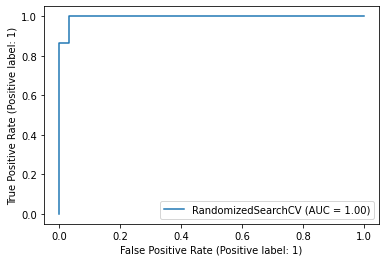

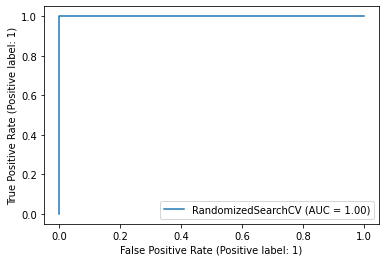

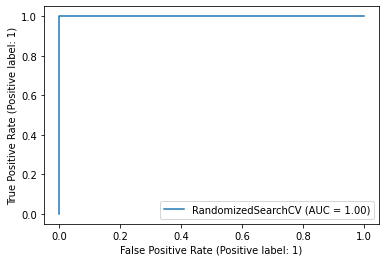

In [133]:
lr_c=plot_roc_curve(rand_lr_search,X_test,y_test)
lgbm_c=plot_roc_curve(rand_lgbm_search,X_test,y_test)
xgb_c=plot_roc_curve(rand_xgb_search,X_test,y_test)


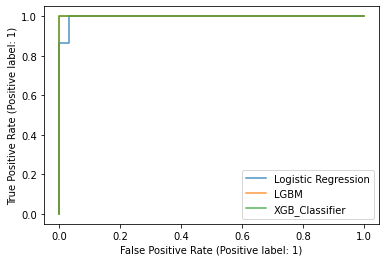

In [135]:
ax = plt.gca()
lr_c.plot(ax=ax,alpha=0.8,label='Logistic Regression')
lgbm_c.plot(ax=ax,alpha=0.8,label='LGBM')
xgb_c.plot(ax=ax,alpha=0.8,label='XGB_Classifier')

## Proyecto ML

La idea del siguiente proyecto es emular una competencia de kaggle, se entregara un conjunto de datos y el objetivo es: 

__Ajustar el mejor modelo que optimice el `F1 score`__

Los datos (se encuentran en la carpeta compartida dentro de 00_DATA) estan divididos en train y en test:

* `fraud_train.csv` contiene los datos que serán usados para entrenar
* `fraud_test.csv` contiene datos que deben ser scoreados (No contiene variable target)

Se debe entregar un csv con una columa que contenga los pronosticos para cada uno de los registros en `fraud_test.csv`.

Las etiquetas correctas del archivo `fraud_test.csv` las tenemos nosotros, las usaremos para comparar sus respuestas y definir quienes son los ganadores del proyecto

In [ ]:
# Linea de ayuda para montar el drive y usar como disco duro (para leer y escribir datos) google drive desde colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Respuesta
